In [1]:
##intial imports and magics
import sys
import os

#%matplotlib inline
#import matplotlib
# Force matplotlib to not use any Xwindows backend.
#matplotlib.use('Agg')

#from scipy.optimize import minimize
import csv
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import statsmodels.api as sm

#plt.style.use('ggplot')

In [6]:
##rpy and required packages
%load_ext rpy2.ipython
#custom modules
import rpy2.robjects as robjects
#if forecast_rpy: del sys.modules['forecast_rpy']
import r_holtwinters_forecast

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
### SET GA AND PROJECT SPECIFIC VARIABLES
profile_number = 'ga:1234567'
start_date = '2011-11-01'
end_date = '2015-10-31'
client_name = 'tbc'

In [13]:
##read data from DB

HttpError: <HttpError 403 when requesting https://www.googleapis.com/analytics/v3/data/ga?max-results=10000&dimensions=ga%3AyearMonth&start-date=2011-11-01&start-index=1&ids=ga%3A12334&metrics=ga%3Asessions%2Cga%3Atransactions%2Cga%3AtransactionRevenue&filters=ga%3Amedium%3D%3Dorganic&alt=json&end-date=2015-10-31 returned "User does not have sufficient permissions for this profile.">

In [73]:
#put GA data into dataframe
df = pd.DataFrame(rows,columns=heads)
#convert sessions column to numeric format
df['ga:sessions'] = df['ga:sessions'].convert_objects(convert_numeric=True)

#create list for R usage
historic_sessions = df['ga:sessions'].tolist()
historic_revenue = df['ga:transactionRevenue'].astype('float').tolist()

### Assessing Data Components

#### Autocorrelation
Non-random data displays ac's close to zero, wheareas seasonaly predictable data should show spikes at even intervals (e.g once every 12 months)

### Decomposition
This should clearly show consistent seasonality, and also gives an idea of growth/shrinking overtime



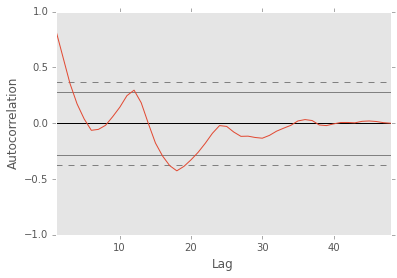

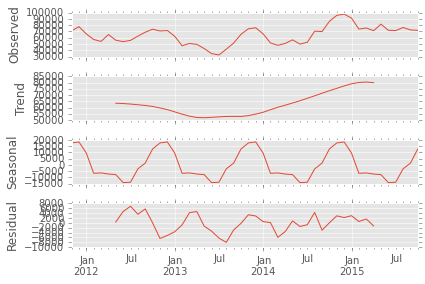

In [11]:
from pandas.tools.plotting import autocorrelation_plot
#plt.figure()

#plot autocorrelations
autocorrelation_plot(historic_sessions)

#create range and plot time series components
rng = pd.date_range(start_date,end_date,freq='MS')
dta = pd.Series(historic_sessions,index=rng)

#decompose historic data and plot 
res = sm.tsa.seasonal_decompose(dta)
resplot = res.plot()

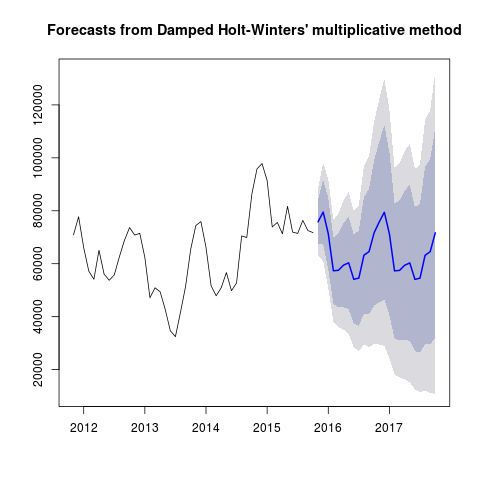

Mean Absolute Percentage Error: 7.00544017748


In [74]:
"""Forecast Sessions"""
#run data through forecast function and convert back to R object
results = forecast_rpy.main(historic_sessions,start_date)
fcast = results[0]
%Rpush fcast
%Rpush historic_sessions

#plot the results
%R plot(fcast)
print 'Mean Absolute Percentage Error: %s'% results[1][4]

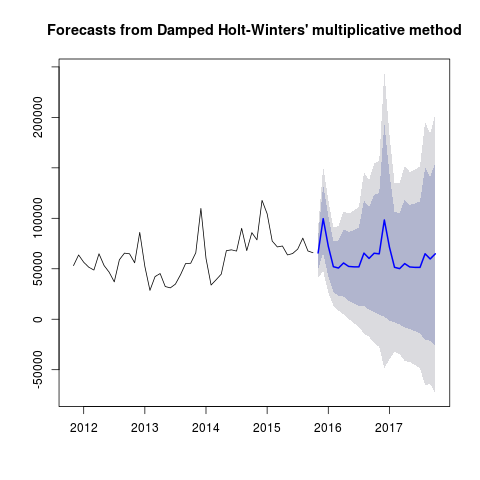

Mean Absolute Percentage Error: 13.8677406847


In [75]:
"""Forecast Revenue"""
#run data through forecast function and convert back to R object
results = forecast_rpy.main(historic_revenue,start_date)
rev_fcast = results[0]
%Rpush rev_fcast
%Rpush historic_revenue

#plot the results
%R plot(rev_fcast)
print 'Mean Absolute Percentage Error: %s'% results[1][4]

In [90]:
'''Extract forecast data and tidy into single data frame'''

#create date range for index
dates = pd.date_range(pd.to_datetime(end_date) +  pd.DateOffset(days=0) +  pd.DateOffset(months=0, days=1), periods=24, freq='MS')

#extract session data from R object
sessions_mean = pd.DataFrame(np.asarray(fcast[1]),columns=['sessions'],index=dates)
session_conf_lower = pd.DataFrame(np.asarray(fcast[5]),columns=['lower80','lower95'],index=dates)
session_conf_upper = pd.DataFrame(np.asarray(fcast[4]),columns=['upper80','upper95'],index=dates)

#extract revenue data from R object
rev_mean = pd.DataFrame(np.asarray(rev_fcast[1]),columns=['transactionRevenue'],index=dates)
rev_conf_lower = pd.DataFrame(np.asarray(rev_fcast[5]),columns=['lower80','lower95'],index=dates)
rev_conf_upper = pd.DataFrame(np.asarray(rev_fcast[4]),columns=['upper80','upper95'],index=dates)

#concatenated sessions and revenue into a single dataframe
forecast_data = pd.concat([sessions_mean,session_conf_lower['lower80'],session_conf_upper['upper80'],rev_mean,rev_conf_lower['lower80'],rev_conf_upper['upper80']], axis=1)

In [97]:
'''Output files to relevant directory'''
results_path = '/home/queryclick/apps/radge/data/forecasts'

#save forecast data
save_url = results_path + '/fcast_%s.csv' % client_name
forecast_data.to_csv(save_url)

#save historic data
historic_url = results_path + '/fcast_%s_historic.csv' % client_name
df.to_csv(historic_url)
